In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a few different labels and study how they affect the generated emebdding space. For now, we focus *povo* and *categoria*.

In [3]:
from PIL import Image

# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open(row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

# Function for preparing labels for dataset training
def preparing_labels(label_column='povo'):
    # label_column = 'povo', 'categoria', 'ano_de_aquisicao'
    name_to_num = {c: i for i, c in enumerate(ind_df[label_column].unique())}
    labels = {row['image_path_br']: name_to_num[row[label_column]] \
              for index, row in ind_df.loc[ind_df['image_path_br'].notna()].iterrows()}
    return labels

1 corrupted images


In [4]:
import os
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function for creating the ImageDataset class and the DataLoader object to avoid loading 
# all the images simultaneously and run out of GPU memory
class ImageDataset(Dataset):
    def __init__(self, image_dir, labels, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) \
                            if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels.get(image_path, -1)
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
labels = preparing_labels('povo')
dataset = ImageDataset("data/br_images/", labels, transform=transform)

## ViT Base Patch-16

### Pre-trained Embedding Space

In [5]:
# Function to iterating over data to get projections
def get_embeddings(model, dataloader, fine_tuned=False):
    image_embeddings = []
    model.eval()
    for batch_images, _ in tqdm(dataloader, desc="Computing embeddings"):
        batch_images = batch_images.to(device)
        with torch.no_grad():
            # Soft "removing" classifier head, if fine-tuned model
            if fine_tuned:
                outputs = model.vit(batch_images)
            else:
                outputs = model(batch_images)
        
        # Do I get the last_hidden_state of CLS token or the pooler_output?
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']
        image_embeddings.append(embeddings.cpu())
    return image_embeddings

In [6]:
import trimap
from sklearn.manifold import TSNE
import umap

# Function for computing data projection
def data_projection(image_embeddings, **kwargs):
    proj_trimap = trimap.TRIMAP(n_dims=2, n_inliers=12, n_outliers=6, n_random=3,\
                                weight_temp=0.5, lr=0.1, apply_pca=True)
    vanilla_vit_trimap = proj_trimap.fit_transform(image_embeddings)
    
    proj_tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto', init='random')
    vanilla_vit_tsne = proj_tsne.fit_transform(image_embeddings)
    
    proj_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')
    vanilla_vit_umap = proj_umap.fit_transform(image_embeddings)

    return vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap

In [7]:
# %%skip

# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
import numpy as np
from transformers import ViTImageProcessor, ViTModel
from tqdm import tqdm

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings = np.concatenate(get_embeddings(model, dataloader), axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projection(image_embeddings)

Computing embeddings: 100%|████| 23/23 [02:41<00:00,  7.03s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
# Cleaning up memory function
def clean_mem(tensors):
    for tensor in tensors:
        del tensor
    torch.cuda.empty_cache()

clean_mem([model, image_embeddings])

### Fine-tuning Embedding Space

In [9]:
# Creating our own ViT classifier head for fine-tuning
import torch.nn as nn
import torch.optim as optim

class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Do I get the last_hidden_state of CLS token or the pooler_output?
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits = self.classifier(embeddings)
        return logits

In [10]:
from torchmetrics.classification import Accuracy, Precision

# Training function
def train_loop(model, num_classes, train_dataloader, val_dataloader, epochs=20):
    losses = []
    accuracies = []
    class_precisions = [[] for i in range(num_classes)]

    # Early-stopping set up
    best_val_acc = 0
    patience = max(3, int(0.05*epochs))
    patience_counter = 0
    tolerance = 0.01

    acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    prec_metric = Precision(task="multiclass", num_classes=num_classes, \
                            average=None).to(device)
    
    for epoch in tqdm(range(epochs), desc=f"Training model", leave=True):
        model.train()
        epoch_loss = .0
        for batch_images, batch_labels in train_dataloader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            
            opt.zero_grad()
            logits = model(batch_images)
            loss = criterion(logits, batch_labels)
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        losses.append(torch.tensor(epoch_loss, dtype=torch.float16).item())

        # Validation set for early-stopping on metrics that are not directly optimized
        model.eval()
        with torch.no_grad():
            all_preds = []
            all_labels = []

            for batch_images, batch_labels in val_dataloader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
                logits = model(batch_images)
                preds = torch.argmax(logits, dim=1)
                
                all_preds.append(preds)
                all_labels.append(batch_labels)
            
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)
            
            val_acc = acc_metric(all_preds, all_labels).item()
            val_prec = prec_metric(all_preds, all_labels).tolist()

        accuracies.append(torch.tensor(val_acc, dtype=torch.float16).item())
        for i, prec in enumerate(val_prec):
            class_precisions[i].append(torch.tensor(prec, dtype=torch.float16).item())

         # Early-stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        
        elif best_val_acc-val_acc > tolerance:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write("Early-stopping training!")
                break
        
        tqdm.write((f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, '
                    f'Validation Accuracy: {val_acc:.4f}'))

    return losses, accuracies, class_precisions

In [12]:
import matplotlib.pyplot as plt

# Function for plotting loss and accuracy curves
def plot_train_curves(losses, accuracies, model_name):
    plt.figure(figsize=(8,4))
    plt.suptitle(f'Loss and Accuracy Curves for {model_name}')
    
    # Plotting loss curve
    plt.subplot(1, 2, 1)
    plt.plot([i+1 for i in range(len(losses))], losses, 'x-', c='b')
    plt.title("Loss x Epoch")
    plt.xlabel("")
    plt.ylabel("")
    
    # Plotting accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot([i+1 for i in range(len(accuracies))], accuracies, 'x-', c='r')
    plt.title("Accuracy x Epoch")
    plt.xlabel("")
    plt.ylabel("")
    
    plt.tight_layout()
    plt.show()

In [13]:
# Function for getting traininig/validation split
def get_train_val_split(dataset, train_size, batch_size=32):
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size], \
                                          generator=torch.Generator().manual_seed(42))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, \
                                  num_workers=0, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, \
                                num_workers=0, pin_memory=True)
    
    return train_dataloader, val_dataloader

#### *povo* Column

In [14]:
# LET'S THINK ABOUT CLASS INBALANCE?

Training model:   7%|▋         | 1/15 [04:16<59:54, 256.73s/it]

Epoch 1, Loss: 1142.1564, Validation Accuracy: 0.4143


Training model:  13%|█▎        | 2/15 [08:36<55:59, 258.44s/it]

Epoch 2, Loss: 811.8489, Validation Accuracy: 0.5242


Training model:  20%|██        | 3/15 [12:43<50:38, 253.19s/it]

Epoch 3, Loss: 600.5944, Validation Accuracy: 0.5904


Training model:  27%|██▋       | 4/15 [16:48<45:52, 250.20s/it]

Epoch 4, Loss: 431.9539, Validation Accuracy: 0.6560


Training model:  33%|███▎      | 5/15 [20:55<41:27, 248.77s/it]

Epoch 5, Loss: 290.9797, Validation Accuracy: 0.6879


Training model:  40%|████      | 6/15 [25:00<37:08, 247.59s/it]

Epoch 6, Loss: 189.2847, Validation Accuracy: 0.7021


Training model:  47%|████▋     | 7/15 [29:04<32:52, 246.56s/it]

Epoch 7, Loss: 123.1535, Validation Accuracy: 0.7181


Training model:  53%|█████▎    | 8/15 [33:08<28:39, 245.67s/it]

Epoch 8, Loss: 76.4451, Validation Accuracy: 0.7376


Training model:  60%|██████    | 9/15 [37:12<24:31, 245.24s/it]

Epoch 9, Loss: 49.9940, Validation Accuracy: 0.7358


Training model:  67%|██████   | 10/15 [41:15<20:21, 244.38s/it]

Epoch 10, Loss: 34.6701, Validation Accuracy: 0.7394


Training model:  73%|██████▌  | 11/15 [45:14<16:10, 242.74s/it]

Epoch 11, Loss: 57.6473, Validation Accuracy: 0.7027


Training model:  73%|██████▌  | 11/15 [49:13<17:54, 268.50s/it]


Early-stopping training!


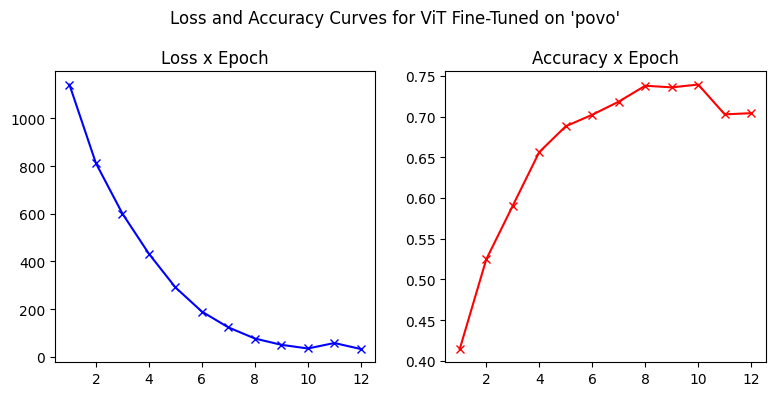

Computing embeddings: 100%|███████| 23/23 [02:27<00:00,  6.41s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
from torch.utils.data import random_split

# Creating training and validation datasets
train_size = int(0.85*len(dataset))
batch_size = 32
train_dataloader, val_dataloader = get_train_val_split(dataset, train_size, batch_size)

# Training set-up and execution for 'povo'
num_classes = ind_df['povo'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0)
epochs = 30

losses, accuracies, class_precisions = train_loop(model, num_classes, train_dataloader, \
                                                  val_dataloader, epochs)
plot_train_curves(losses, accuracies, "ViT Fine-Tuned on 'povo'")

# Computing image embeddings
model.classifier = nn.Identity()
image_embeddings = np.concatenate(get_embeddings(model, dataloader, True), axis=0)

# Computing data projection
povo_vit_trimap, povo_vit_tsne, povo_vit_umap = data_projection(image_embeddings)

#### *categoria* Column

Training model:   7%|▊            | 1/15 [04:04<57:01, 244.41s/it]

Epoch 1, Loss: 304.8584, Validation Accuracy: 0.8002


Training model:  13%|█▋           | 2/15 [08:06<52:42, 243.31s/it]

Epoch 2, Loss: 110.1285, Validation Accuracy: 0.8836


Training model:  20%|██▌          | 3/15 [12:14<49:03, 245.30s/it]

Epoch 3, Loss: 48.9134, Validation Accuracy: 0.8871


Training model:  27%|███▍         | 4/15 [16:28<45:34, 248.61s/it]

Epoch 4, Loss: 27.4850, Validation Accuracy: 0.8777


Training model:  33%|████▎        | 5/15 [20:42<41:47, 250.72s/it]

Epoch 5, Loss: 18.9693, Validation Accuracy: 0.8883


Training model:  40%|█████▏       | 6/15 [24:56<37:45, 251.73s/it]

Epoch 6, Loss: 14.1124, Validation Accuracy: 0.8918


Training model:  47%|██████       | 7/15 [29:14<33:50, 253.80s/it]

Epoch 7, Loss: 9.1090, Validation Accuracy: 0.8936


Training model:  53%|██████▉      | 8/15 [33:31<29:44, 254.87s/it]

Epoch 8, Loss: 13.4659, Validation Accuracy: 0.8735


Training model:  60%|███████▊     | 9/15 [37:49<25:35, 255.84s/it]

Epoch 9, Loss: 5.6716, Validation Accuracy: 0.8966


Training model:  67%|████████    | 10/15 [42:07<21:22, 256.58s/it]

Epoch 10, Loss: 4.5569, Validation Accuracy: 0.8918


Training model:  73%|████████▊   | 11/15 [46:23<17:04, 256.14s/it]

Epoch 11, Loss: 14.7836, Validation Accuracy: 0.8877


Training model:  80%|█████████▌  | 12/15 [50:33<12:42, 254.32s/it]

Epoch 12, Loss: 4.7972, Validation Accuracy: 0.8972


Training model:  87%|██████████▍ | 13/15 [54:38<08:23, 251.56s/it]

Epoch 13, Loss: 4.5231, Validation Accuracy: 0.8936


Training model:  93%|███████████▏| 14/15 [58:43<04:09, 249.54s/it]

Epoch 14, Loss: 4.9206, Validation Accuracy: 0.8883


Training model: 100%|██████████| 15/15 [1:02:47<00:00, 251.20s/it]


Epoch 15, Loss: 2.8908, Validation Accuracy: 0.8848


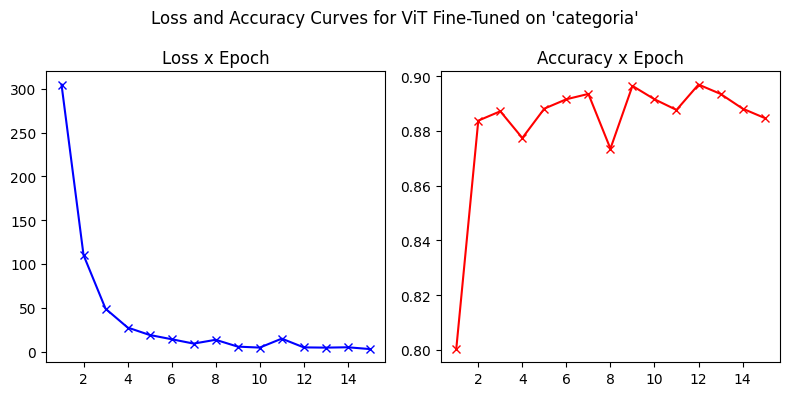

Computing embeddings: 100%|███████| 23/23 [02:30<00:00,  6.53s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
# Cleaning up memory
clean_mem([model, image_embeddings])

# Preparing dataset for next training process
labels = preparing_labels('categoria')
dataset = ImageDataset("data/br_images/", labels, transform=transform)

train_size = int(0.85*len(dataset))
batch_size = 32
train_dataloader, val_dataloader = get_train_val_split(dataset, train_size, batch_size)

# Training set-up and execution for 'categoria'
num_classes = ind_df['categoria'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0)
epochs = 20

losses, accuracies, class_precisions = train_loop(model, num_classes, train_dataloader, \
                                                  val_dataloader, epochs)
plot_train_curves(losses, accuracies, "ViT Fine-Tuned on 'categoria'")

# Computing image embeddings
model.classifier = nn.Identity()
image_embeddings = np.concatenate(get_embeddings(model, dataloader, True), axis=0)

# Computing data projection
categoria_vit_trimap, categoria_vit_tsne, \
categoria_vit_umap = data_projection(image_embeddings)

In [22]:
# Cleaning up memory
clean_mem([model, image_embeddings])

### Visualizing and Comparing Projections

In [17]:
# Function for normalizing projections to [-norm_factor, norm_factor] while maintaining
# relative distances
def normalize(data, norm_factor=2):
    mean = np.mean(data)
    max_dev = np.max(np.abs(data-mean))
    
    return norm_factor*(data-mean)/max_dev

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

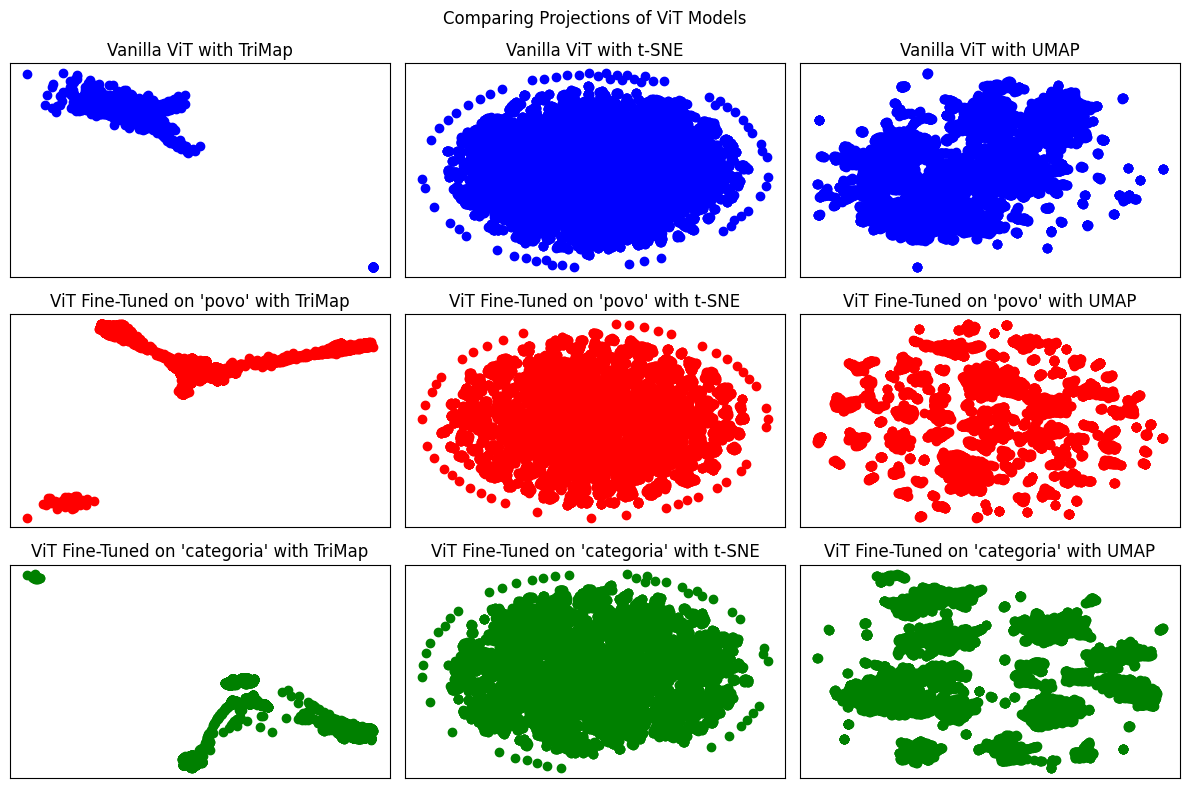

In [21]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
for i, (vanilla_vit, proj_name) in enumerate(zip([vanilla_vit_trimap, \
                                                  vanilla_vit_tsne, vanilla_vit_umap], \
                                                 ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+1)
    plt.scatter(vanilla_vit[:, 0], vanilla_vit[:, 1], c='b')
    plt.title("Vanilla ViT with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

# Plotting ViT fine-tuned on 'povo' projections
for i, (povo_vit, proj_name) in enumerate(zip([povo_vit_trimap, \
                                               povo_vit_tsne, povo_vit_umap], \
                                              ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+4)
    plt.scatter(povo_vit[:, 0], povo_vit[:, 1], c='r')
    plt.title("ViT Fine-Tuned on 'povo' with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

# Plotting ViT fine-tuned on 'categoria' projections
for i, (categoria_vit, proj_name) in enumerate(zip([categoria_vit_trimap, \
                                                    categoria_vit_tsne, categoria_vit_umap], \
                                                   ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+7)
    plt.scatter(categoria_vit[:, 0], categoria_vit[:, 1], c='g')
    plt.title("ViT Fine-Tuned on 'categoria' with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

### Visualizing Clusters

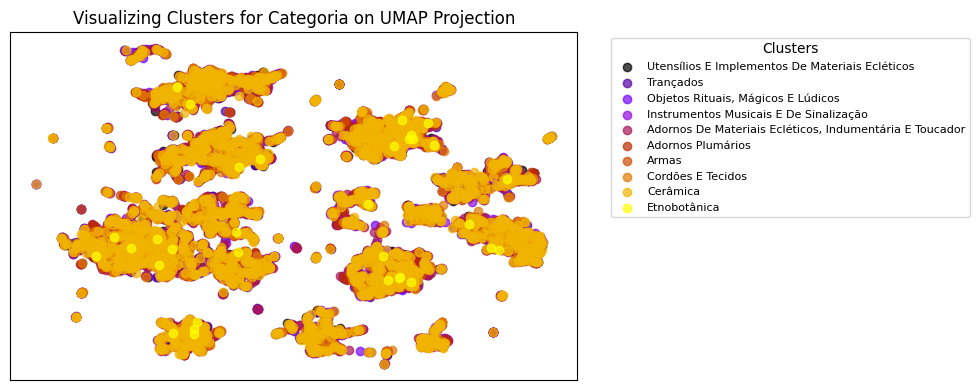

In [85]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Building colormap for cluster visualization
column = 'categoria' # 'povo', 'categoria', 'ano_de_aquisicao'
unique_values = filtered_df[column].unique()
colors = plt.cm.gnuplot(np.linspace(0, 1, len(unique_values)))
color_dict = {cluster: colors[i] for i, cluster in enumerate(unique_values)}

# Plotting projections with clusters
plt.figure(figsize=(10,4))

for cluster in unique_values:
    mask = filtered_df.index[filtered_df[column] == cluster].tolist()
    sequential_indices = np.array([filtered_df.index.get_loc(idx) for idx in mask])
    plt.scatter(categoria_vit_umap[sequential_indices, 0], \
                categoria_vit_umap[sequential_indices, 1], 
                color=color_dict[cluster], label=f"{cluster.title()}", alpha=0.7)

plt.title(f"Visualizing Clusters for Categoria on UMAP Projection")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left", \
           fontsize=8, frameon=True)

plt.tight_layout()
plt.show()

In [ ]:
# Saving outputs for visualization tool
